# Modelling: Text Classification for dog whistles using LLMs

## Setup

### Importing necessary Libraries

In [ ]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import gzip
import json
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Importing transformer libraries
from transformers import AutoModel, AutoTokenizer
import torch

# Reading in necessary Word2Vec libraries
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import sent_tokenize, word_tokenize
from gensim.models import Word2Vec

In [ ]:
# Reading in data
all_posts = pd.read_csv('./all_posts.csv',on_bad_lines='skip', engine='python')

Mounted at /content/drive


### Train-test splitting data

In [ ]:
# Train-test split
X = all_posts['posts'] # Text of post
y = all_posts['dw'] # Target Variable (contains dog whistle)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## LLM Word Embedding Classification

### Distilbert Uncased Model - Generating Word Embeddings

In [ ]:
# Choose a model
model_name = "distilbert-base-uncased" # Choosing distilbert for compactness and flexibility
tokenizer = AutoTokenizer.from_pretrained(model_name) # Initializing tokenizer
model = AutoModel.from_pretrained(model_name) # Initializing model


In [70]:
# Defining function to get embeddings
def get_embeddings(text):
    '''Tokenizer with padding and max length'''
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    '''Generate embeddings'''
    with torch.no_grad():
        outputs = model(**inputs)
        embeddings = outputs.last_hidden_state.mean(dim=1)  # Average pooling
    return embeddings



In [ ]:
# Get embeddings for each observation in training data
embeds = []
for i in list(X_train):
  embeds.append(get_embeddings(i))


In [72]:
# Creating data frame of training data and embeddings
dw_trained = pd.DataFrame((X_train[0:len(embeds)]))
dw_trained['embeds'] = list(embeds)

In [ ]:
# Exporting to csv
dw_trained.to_csv('./dw_trained.csv', index=False)

In [ ]:
dw_trained = pd.read_csv('./dw_trained.csv',on_bad_lines='skip', engine='python')

### Prediction Model #1: Embedding distances with KNN

In [ ]:
# Spliting into training features and target
X_dw = np.mean(embeds, axis=1) # mean of embeddings for training embeddings
y_dw = y_train[0:len(embeds)] # labels

In [ ]:
# Imputation for missing values in target
y_dw.isna().sum()
y_dw = y_dw.fillna(1) # fill with DW=1 if missing

In [76]:
# Fitting KNN model
knn = KNeighborsClassifier(n_neighbors=3, metric='cosine')
knn.fit(X_dw, y_dw)

KNeighborsClassifier(metric='cosine', n_neighbors=3)

In [16]:
# Perform 5-fold cross-validation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(knn, X_dw, y_dw, cv=5, scoring='accuracy')

print(f"Cross-Validation Accuracy Scores: {scores}")
print(f"Mean Accuracy: {scores.mean() * 100:.2f}%")
print(f"Standard Deviation: {scores.std() * 100:.2f}%")

Cross-Validation Accuracy Scores: [0.94648693 0.93954248 0.95240041 0.94504597 0.94668029]
Mean Accuracy: 94.60%
Standard Deviation: 0.41%


In [17]:
# Generating embeddings for first 100 observations in test set
test_embeds = []
for i in list(X_test)[0:100]:
  test_embeds.append(get_embeddings(i))

In [18]:
# Creating list of predicted values for first 100 obs in test set
test_embeds_preds = [knn.predict(i) for i in test_embeds]

In [19]:
# Creating df for true v. predicted values
tvp = pd.DataFrame({
    "predictions" : list(test_embeds_preds),
    "true_vals" : list(y_test[0:100])}
    )
tvp['predictions'] = tvp['predictions'].astype(int)
tvp['true_vals'] = tvp['true_vals'].astype(int)

In [20]:
# Defining function for generating confusion matrix
def create_confusion_matrix(y_true, y_pred, title):
  from sklearn.metrics import confusion_matrix

  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title(title)
  plt.show()

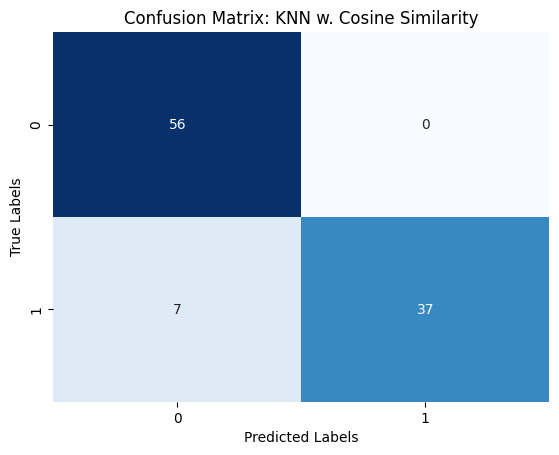

In [ ]:
# KNN Confusion Matrix
create_confusion_matrix(tvp.true_vals, tvp.predictions, "Confusion Matrix: KNN w. Cosine Similarity")

In [ ]:
tvp['correct_pred'] = [1 if x == y else 0 for x, y in zip(tvp['true_vals'], tvp['predictions'])]

In [ ]:
# Test accuracy
accuracy_score(test_embeds_preds, y_test[0:100])

0.93

### Prediction Model #2: Logistic Regression with Embeddings

In [ ]:
# LogReg

test_embeds_array = np.vstack([t.cpu().numpy() for t in test_embeds]) # Getting embeddings for test data

clf = LogisticRegression() # Initialzing Logistic Regression
clf.fit(X_dw, y_dw) # Fitting
y_pred_embed = clf.predict(test_embeds_array) # Getting Predictions
accuracy_score(y_pred_embed, y_test[0:100]) # Accuracy Score

0.95

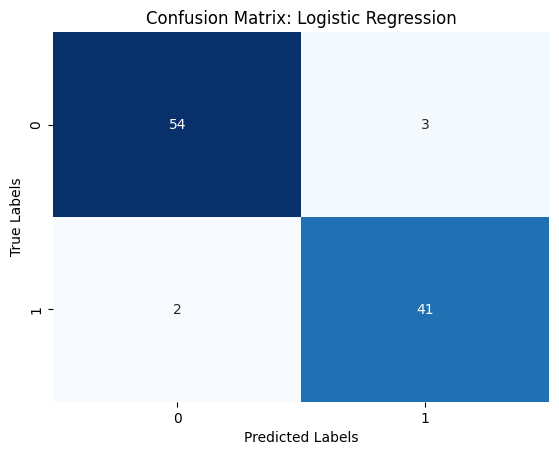

In [ ]:
# LogReg Confusion Matrix
create_confusion_matrix(y_pred_embed, y_test[0:100], "Confusion Matrix: Logistic Regression")

## Word2Vec Embedding Classification

### Prediction Model #3: Word2Vec Embeddings Logistic Regression



In [ ]:
# Getting tokenized sentences for training data text
tokenized_sentences = [word_tokenize(str(sentence)) for sentence in X_train]

In [ ]:
# Getting Word2Vec model
model = Word2Vec(tokenized_sentences, vector_size=100, window=5, min_count=1, workers=4) # first 100 char

In [64]:
# Defining function to get word embeddings
def get_sentence_embedding(sentence, model):
    embeddings = [model.wv[word] for word in sentence if word in model.wv]
    return np.mean(embeddings, axis=0)


In [ ]:
# Generate embeddings for each sentence in training data
sentence_embeddings = [get_sentence_embedding(sentence, model) for sentence in tokenized_sentences]

In [ ]:
# Fitting logistic regression
clf = LogisticRegression()
y_train_w2v = y_train.fillna(1)
clf.fit(sentence_embeddings, y_train_w2v)

LogisticRegression()

In [ ]:
# Getting test data embeddings
X_test_w2v = [get_sentence_embedding(word_tokenize(str(sentence)), model) for sentence in X_test] # features

In [ ]:
# Get prediction for test data
w2v_pred = clf.predict(X_test_w2v)

In [ ]:
# True target values for test data
w2v_true = y_test.fillna(1)

In [ ]:
# Accuracy score
accuracy_score(w2v_true, w2v_pred)

0.9288702928870293

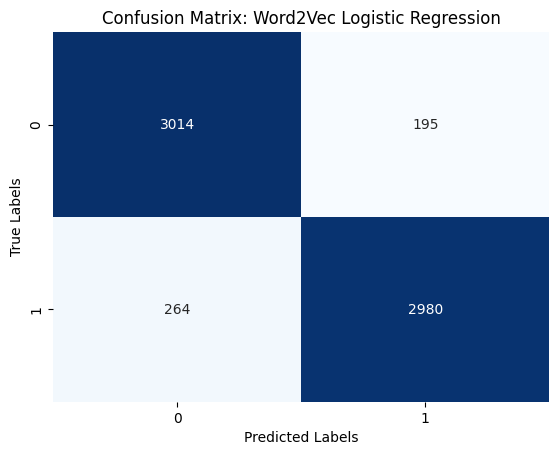

In [ ]:
# Word2Vec LogReg Confusion matrix
create_confusion_matrix(w2v_true, w2v_pred, "Confusion Matrix: Word2Vec Logistic Regression")


### Prediction Model #4: Word2Vec Embeddings KNN


In [ ]:
# Fitting KNN model
knn = KNeighborsClassifier(n_neighbors=3, metric='cosine')
knn.fit(sentence_embeddings, y_train_w2v)

KNeighborsClassifier(metric='cosine', n_neighbors=3)

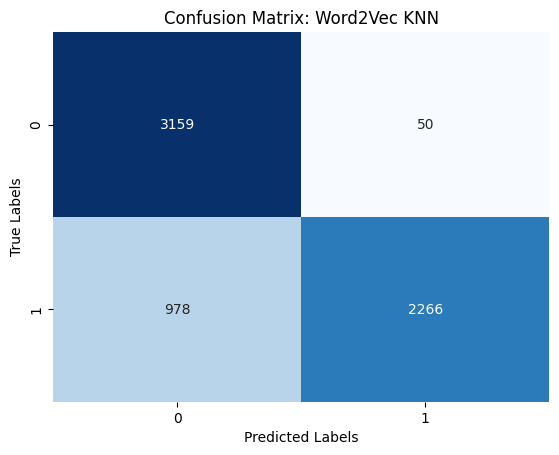

In [ ]:
# predictions v. true values
w2v_pred_knn = knn.predict(X_test_w2v) # preds

# Accuracy score
accuracy_score(w2v_true, w2v_pred_knn)

# Word2Vec KNN Confusion Matrix
create_confusion_matrix(w2v_true, w2v_pred_knn, "Confusion Matrix: Word2Vec KNN")

## Real world example

In [25]:
# Tweet containing DW
new_text = get_embeddings("THANK YOU, NORTH CAROLINA! For the past 9 years, we have been fighting against the most sinister and corrupt forces on earth. With your vote in this election, you can show them once and for all that this nation does NOT belong to THEM... It was hardworking Patriots like you who built this Country—and TOMORROW, it is hardworking Patriots like you who are going to SAVE our Country.")

In [26]:
knn.predict(new_text)

array([1.])

In [27]:
# Reddit posting containing no DW
new_text2 = get_embeddings("Everything I am today—the beliefs I hold, the way I see the world, and the way I carry myself—are pieces I’ve picked up along the way. I taught myself most of it, soaking up what I could from the people I’ve met, books I’ve read, and art that’s stuck with me.")

In [60]:
knn.predict(new_text2)

array([0.])

The above posts were correctly predicted as either containing or not containing a dog whistle, respectively. 